In [1]:
import sys, os
import pandas as pd

path_to_AI16CP2 = '../../AI_16_CP2'
sys.path.insert(0, path_to_AI16CP2)

In [2]:
from utils.trainData import *
excel_path = '../../datasets/High_Resolution/AI_Hub_gender_with_path_sheet.xlsx'
image_data_root = '../../datasets/High_Resolution'
df_id_label, df_paths = get_df_from_excel(excel_path, image_data_root )

model_name = 'vggface'
metric = 'euclidean'

In [3]:
print(df_id_label)
print(df_paths)

           ID  gender                       id_image_data_root
0    19062421       1  ../../datasets/High_Resolution\19062421
1    19062431       1  ../../datasets/High_Resolution\19062431
2    19062521       0  ../../datasets/High_Resolution\19062521
3    19062531       0  ../../datasets/High_Resolution\19062531
4    19062542       0  ../../datasets/High_Resolution\19062542
..        ...     ...                                      ...
395  19101441       1  ../../datasets/High_Resolution\19101441
396  19101442       0  ../../datasets/High_Resolution\19101442
397  19101443       1  ../../datasets/High_Resolution\19101443
398  19101512       1  ../../datasets/High_Resolution\19101512
399  19101513       0  ../../datasets/High_Resolution\19101513

[400 rows x 3 columns]
                     path
0     S001\L1\E01\C15.jpg
1     S001\L1\E01\C16.jpg
2     S001\L1\E01\C17.jpg
3     S001\L1\E01\C19.jpg
4     S001\L1\E01\C20.jpg
...                   ...
4297   S006\L9\E03\C5.jpg
4298   S006\

In [4]:
def create_df_image_paths(row):
    paths = df_paths['path'].apply(lambda x: os.path.join(row, x))
    return pd.DataFrame(paths)

# 각 행에 데이터프레임을 저장
img_path_2dseries = df_id_label['id_image_data_root'].apply(create_df_image_paths)

print(img_path_2dseries)
print(type(img_path_2dseries))

0                                                    ...
1                                                    ...
2                                                    ...
3                                                    ...
4                                                    ...
                             ...                        
395                                                  ...
396                                                  ...
397                                                  ...
398                                                  ...
399                                                  ...
Name: id_image_data_root, Length: 400, dtype: object
<class 'pandas.core.series.Series'>


In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)  # 각 열의 너비를 최대로 설정
del df_id_label
del df_paths

In [6]:
from utils.face_detector import FacePreparer
preparer = FacePreparer()


In [7]:
import random
import numpy as np
from tqdm import tqdm
from utils.function.generals import load_image


pd.reset_option('max_colwidth')


# 추출 불가 이미지 리스트
invalid_image_tuple_list = []
boom_turn = 0
def get_img(idx, j):
    img = None
    if (idx, j) in invalid_image_tuple_list:
        return None
    df = img_path_2dseries.iloc[idx]
    img_path = df['path'].iloc[j]
    img_255 = load_image(img_path) 
    face_list = preparer.detect_faces(img_255, model_name)
    if len(face_list) >0:
        img = face_list[0] / 255 # 정규화된 동일 이미지 원본
    else:
        invalid_image_tuple_list.append((idx, j))
    
    # return [len(img_path)]*2 #test 용
    return img

import matplotlib.pyplot as plt

# pair_img_source: 노멀라이즈된 이미지 페어
# 이미지 페어가 (2, H, W, C) 형태로 있다고 가정합니다.

def plot_pairs(img1, img2, img3, img4):
    # 첫번째 이미지
    plt.subplot(2, 2, 1)
    plt.imshow(img1)
    plt.title('Origin')

    # 두번째 이미지
    plt.subplot(2, 2, 2)
    plt.imshow(img2)
    plt.title('Different')
    
    # 첫번째 이미지
    plt.subplot(2, 2, 3)
    plt.imshow(img3)
    plt.title('Origin')

    # 두번째 이미지
    plt.subplot(2, 2, 4)
    plt.imshow(img4)
    plt.title('Same person')

    # 이미지 플롯 보여주기
    plt.show()
    input('Press Enter to continue...')



# for idx, df in tqdm(enumerate(img_path_2dseries)):
def generator(df_series, generator_batch= 32, num_per_id=50): # df로 된 시리즈
    """
        num_per_id * 390(id) * 2 (True, False) = 최대 쌍수
    """
    for idx, df in enumerate(df_series):
        # if idx >= 1: # 테스트용
        if idx >= len(img_path_2dseries) - 1 - 10: # 390 이상부터 랜덤 추출할 수가 적어 찾는데 시간이 많이 걸릴 수 있고, 에러가 발생할 수 있음(train, val에선 조건이 성립하지 않음)
            return
        
        used_img_list = []
        pair_img_source = None
        while pair_img_source is None:
            random_index = random.randint(0, len(df) - 1)
            pair_img_source = get_img(idx, random_index) # 동일쌍 타겟
        
        pair_source_list = []
        pair_target_list = []
        label_list = []
        
        # 샘플 추출
        random_numbers = random.sample(range(0, 4302), num_per_id)

        for j_index, j in enumerate(random_numbers): # 0 ~ 4301
            true_pair_img_target = get_img(idx, j) # 동일쌍 비동일쌍에서 둘다 원본으로 편성.
            if true_pair_img_target is None:
                continue
            
            false_pair_img_target = None
            random_i = ''
            random_j = ''
            while_cnt = -1
            while false_pair_img_target is None:
                while_cnt += 1
                if while_cnt >= len(df): #while_cnt를 inner_df 길이 이상으로 했으면 충분히 찾았다고 치고 그냥 넘어감
                    break
                random_i = random.randint(idx+1, len(img_path_2dseries) - 1)
                random_j = random.randint(0, len(df) - 1)
                if (random_i, random_j) in used_img_list: # 이미지가 이번 id(0~399) 포문중에 쓰였다면 넘어감
                    continue
                false_pair_img_target = get_img(random_i, random_j) # 비동일쌍 타겟

            used_img_tuple = (random_i, random_j)
            used_img_list.append(used_img_tuple)

            # 모든 쌍 요소와 라벨이 존재하므로 추가할 수 있음
            # if(count == 5):
            #     count = 0
            #     break
            
            # 구성된 샴네트워크가 (이미지, 이미지), 라벨로 받길 원하는게 아니라, [배치수, (이미지리스트, 이미지리스트), 라벨]로 받길 원함
            pair_source_list.append(pair_img_source)
            pair_target_list.append(true_pair_img_target)
            label_list.append(1)
            
            #테스트용
            # print(pair_img_source.shape)
            
            pair_source_list.append(pair_img_source)
            pair_target_list.append(false_pair_img_target)
            label_list.append(0)

            
                            
            #테스트용
            # plot_pair(pair_img_source, false_pair_img_target, pair_img_source, true_pair_img_target)

            # label_list가 제너레이터 배치보다 크거나 j_index가 마지막 인덱스 이상일때
            if len(label_list) >= generator_batch or j_index >= len(random_numbers) - 1:
                # 리스트를 NumPy 배열로 변환
                pair_source_array = np.array(pair_source_list, dtype=np.float32)
                pair_source_list.clear()
                pair_target_array = np.array(pair_target_list, dtype=np.float32)
                pair_target_list.clear()
                label_array = np.array(label_list, dtype=np.int32)
                label_list.clear()
                
                yield (pair_source_array, pair_target_array), label_array

In [8]:
from sklearn.model_selection import train_test_split

def split_dataset(df_series, test_size=0.2, random_state=42):
    train_df_series, val_df_series = train_test_split(df_series, test_size=test_size, random_state=random_state)
    return train_df_series, val_df_series

train_df_series, val_df_series = split_dataset(img_path_2dseries, test_size=0.2)
train_df_series

3                                                    ...
18                                                   ...
202                                                  ...
250                                                  ...
274                                                  ...
                             ...                        
71                                                   ...
106                                                  ...
270                                                  ...
348                                                  ...
102                                                  ...
Name: id_image_data_root, Length: 320, dtype: object

In [9]:
from utils.face_verifier2 import Verifier2
from utils.math import get_contrastive_loss
import tensorflow as tf

learning_rate = 0.0001

verifier = Verifier2(model_name, metric)
#############################
verifier.model.load_weights('vggface_weights/vggface_weights_09.h5')
#############################

# 손실 함수, 평가 지표 정의
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9, momentum=0.9, epsilon=1e-6)
loss = ["binary_crossentropy"] #contrastive(거리값으로 대조할 때) / 이진분류의 대표적 손실함수 
metrics = ["accuracy"]

verifier.model.compile(
    optimizer=opt,
    loss=loss,
    metrics=metrics
)


In [10]:
verifier.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 2622)         151880384   ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

In [11]:
verifier.model.input_shape

[(None, 224, 224, 3), (None, 224, 224, 3)]

In [12]:
import os, math
from tensorflow.keras.callbacks import TensorBoard

dir_path = "./vggface_weights"
POST_FIX = '_weights_03epoch_{epoch:02d}-{val_accuracy:.3f}.h5'
# BATCH_SIZE = 4
BATCH_SIZE = 64
NUM_PER_ID = 192
# NUM_PER_ID = 1 #테스트
EPOCHS = 3
PATIENCE = 3

# log_dir = '/logs'  # 로그가 저장될 디렉토리
# tensorboard_callback = TensorBoard(log_dir=os.path.join(dir_path, log_dir), histogram_freq=1, update_freq=1)

if not os.path.exists(dir_path):
    os.mkdir(dir_path)

output_signature = (
    (tf.TensorSpec(shape=verifier.model.input_shape[0], dtype=tf.float32),
     tf.TensorSpec(shape=verifier.model.input_shape[1], dtype=tf.float32)),
    tf.TensorSpec(shape=(None,), dtype=tf.int32)
)

train_ds = tf.data.Dataset.from_generator(
    generator= lambda: generator(train_df_series, BATCH_SIZE * 2, NUM_PER_ID),
    output_signature=output_signature,
).repeat()
# train_generator = generator(train_df_series, EPOCHS, BATCH_SIZE * 2, NUM_PER_ID)

val_ds = tf.data.Dataset.from_generator(
    generator= lambda: generator(val_df_series, BATCH_SIZE * 2, NUM_PER_ID),
    output_signature=output_signature,
    # output_types=((tf.float32, tf.float32), tf.int32), #deprecated
    # output_shapes=( (verifier.model.input_shape[0], verifier.model.input_shape[1]), None ), #deprecated
).repeat()
# val_generator = generator(val_df_series, EPOCHS, BATCH_SIZE * 2, NUM_PER_ID)

# 데이터셋 테스트
# for elem in train_ds.take(1):
#     print(elem)
# for elem in val_ds.take(1):
#     print(elem)


# 스텝 설정
steps_per_epoch = math.ceil(len(train_df_series) * NUM_PER_ID * 2 / BATCH_SIZE) # 사실 미묘하게 안맞는데 비슷해서 이렇게 씀
validation_steps = math.ceil(len(val_df_series) * NUM_PER_ID * 2 / BATCH_SIZE) # 사실 미묘하게 안맞는데 비슷해서 이렇게 씀


run_options = tf.compat.v1.RunOptions()
run_options.report_tensor_allocations_upon_oom = True


# # 가중치파일 최신 10개만 남김
# def keep_latest_n_weights(dir_path, n=10):
#     if not os.path.exists(dir_path):
#         os.mkdir(dir_path)
#         return
    
#     weights_files = sorted([f for f in os.listdir(dir_path) if f.endswith('.h5')], 
#                            key=lambda x: os.path.getmtime(os.path.join(dir_path, x)), reverse=True)
#     for f in weights_files[n:]:
#         os.remove(os.path.join(dir_path, f))

# LambdaCallback 설정
keep_latest_weights_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: keep_latest_n_weights(dir_path, n=10)
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'{dir_path}/' + model_name + POST_FIX,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=False,
    save_freq='epoch', # 1에폭마다 저장함
    verbose=1,
)

early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

history = verifier.model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    # callbacks=[checkpoint_callback, early, tensorboard_callback],
    callbacks=[checkpoint_callback, early],
    batch_size = BATCH_SIZE,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_steps= validation_steps
)

Epoch 1/3
1920/1920 [==============================] - ETA: 0s - loss: 0.6291 - accuracy: 0.6452

KeyboardInterrupt: 

In [13]:
verifier.model.save_weights('vggface_weights/vggface_weights_10.h5')

In [ ]:
(verifier.model.input_shape[0], verifier.model.input_shape[1])

((None, 224, 224, 3), (None, 224, 224, 3))

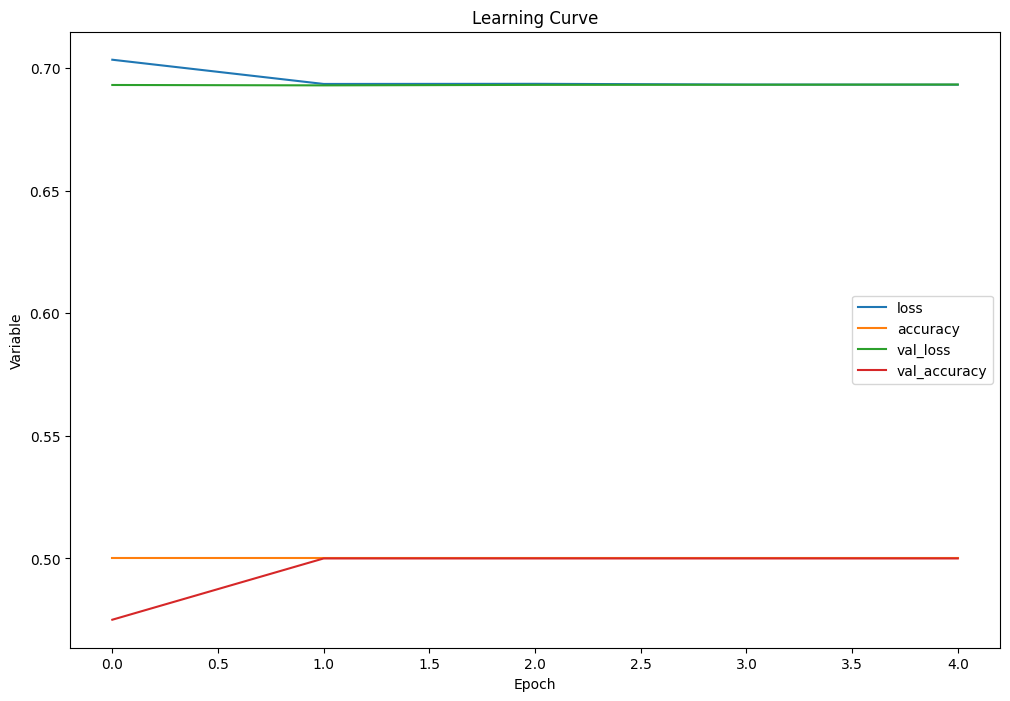

In [ ]:
from utils.plot import plot_history
plot_history(history)

In [ ]:
for layer in verifier.model.layers:
    print(layer.name, layer.trainable)


input_1 True
input_2 True
model True
distance_layer True
dense True


In [ ]:
model_name = 'arcface'
metric = 'cosine'
learning_rate = 0.0002

verifier = Verifier2(model_name, metric)

# 손실 함수, 평가 지표 정의
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9, momentum=0.9, epsilon=1e-6)
loss = ["binary_crossentropy"] # contrastive(거리값으로 대조할 때) / 이진분류의 대표적 손실함수 
metrics = ["accuracy"]

verifier.model.compile(
    optimizer=opt,
    loss=loss,
    metrics=metrics
)

In [ ]:
verifier.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_resnet_v1 (Functiona  (None, 512)         23497424    ['input_3[0][0]',                
 l)                                                               'input_4[0][0]']          

In [ ]:
verifier.model.input_shape

[(None, 160, 160, 3), (None, 160, 160, 3)]

In [ ]:
import os, math
dir_path = "./arcface_weights"
BATCH_SIZE = 64
# NUM_PER_ID * 2 가 BATCH_SIZE 미만이면 BATCH_SIZE가 의미가 없음. 어차피 NUM_PER_ID * 2 씩만 가져와서 학습하게 되기 때문.
NUM_PER_ID = 320
# NUM_PER_ID = 128 # test용
EPOCHS = 5
PATIENCE = 5

if not os.path.exists(dir_path):
    os.mkdir(dir_path)


output_signature = (
    (tf.TensorSpec(shape=verifier.model.input_shape[0], dtype=tf.float32),
     tf.TensorSpec(shape=verifier.model.input_shape[1], dtype=tf.float32)),
    tf.TensorSpec(shape=(None,), dtype=tf.int32)
)

train_ds = tf.data.Dataset.from_generator(
    generator= lambda: generator(train_df_series, BATCH_SIZE * 2, NUM_PER_ID),
    output_signature=output_signature,
).repeat()
# train_generator = generator(train_df_series, EPOCHS, BATCH_SIZE * 2, NUM_PER_ID)

val_ds = tf.data.Dataset.from_generator(
    generator= lambda: generator(val_df_series, BATCH_SIZE * 2, NUM_PER_ID),
    output_signature=output_signature,
    # output_types=((tf.float32, tf.float32), tf.int32),
    # output_shapes=( (verifier.model.input_shape[0], verifier.model.input_shape[1]), None ),
).repeat()


# 스텝 설정
steps_per_epoch = math.ceil(len(train_df_series) * NUM_PER_ID * 2 / BATCH_SIZE)
validation_steps = math.ceil(len(val_df_series) * NUM_PER_ID * 2 / BATCH_SIZE)


run_options = tf.compat.v1.RunOptions()
run_options.report_tensor_allocations_upon_oom = True


# 가중치파일 최신 10개만 남김
def keep_latest_n_weights(dir_path, n=10):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
        return
    
    weights_files = sorted([f for f in os.listdir(dir_path) if f.endswith('.h5')], 
                           key=lambda x: os.path.getmtime(os.path.join(dir_path, x)), reverse=True)
    for f in weights_files[n:]:
        os.remove(os.path.join(dir_path, f))

# LambdaCallback 설정
keep_latest_weights_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: keep_latest_n_weights(dir_path, n=10)
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'{dir_path}/' + model_name + POST_FIX,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=False,
    save_freq='epoch', # 1에폭마다 저장함
    verbose=1,
)

early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

history2 = verifier.model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_callback, early, keep_latest_weights_callback],
    batch_size = BATCH_SIZE,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_steps= validation_steps
)



TypeError: generator() takes from 1 to 3 positional arguments but 4 were given

In [ ]:
# ds_count = tf.data.Dataset.from_generator(
#     generator= lambda: generator(train_df_series, BATCH_SIZE * 2, NUM_PER_ID),
#     output_types=((tf.float32, tf.float32), tf.int32),
#     output_shapes=(((None, 2), (None, 2)), None),
# )
# ds_count.repeat(3)

<RepeatDataset element_spec=((TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>

In [ ]:
plot_history(history2)

In [ ]:
# import tensorflow as tf
# import numpy as np


# def our_generator():
#     for i in range(1000):
#       print(len(train_df_series))
#       x = np.random.rand(28,28)
#       y = np.random.randint(1,10, size=1)
#       yield x,y

# dataset = tf.data.Dataset.from_generator()

# for batch, (x,y) in enumerate(dataset):
#   pass

# print("batch: ", batch)
# print("Data shape: ", x.shape, y.shape)
# print(x[0])
# print(y[0])

#batch:  999
#Data shape:  (28, 28) (1,)

TypeError: 'Series' object is not callable